In [1]:
from IPython.core.display import Image, display
display(Image(url='https://www.greekmythology.com/images/mythology/aegis_228.jpg', width=200, unconfined=True))

/tmp/ipykernel_2546146/4129434108.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
import numpy as np
import healpy as hp
import pickle as pk
import torch
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns
from os import listdir
import os
import sys
sys.path.append('../astroLFI')
import LFI_galactic_center
from sources import FermiBackgrounds
from sources import Model_O
from sources import DMsignal
from sources import smoothDM
from sources import MSP
from sources import Fermi_Bubbles
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples

%matplotlib inline

In [3]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5 + 20*2 #kpc
#exposure = 10*2000*10*0.2 #cm^2 yr
exposure = 2000*10*0.2 #cm^2 yr
#exposure = 200*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
#flux_cut = np.inf
angular_cut = 10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5*0.5

In [4]:
# Add core non-poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_np_wrap(r, params):
    A = params[start1_i]
    #A = 0.035
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_np_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[start1_i+1] #1e34
    L_b = 1.56e37/2.35 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(0.07)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_np_als = [(R_core_np_wrap, Theta_core_np_wrap, Phi_core_np_wrap), L_core_np_wrap, spec_core_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_np_als)
source_class_list.append('independent_spherical_multi_spectra')

In [ ]:
# Add core poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_p_wrap(r, params):
    A = params[start1_i]
    #A = 1.0
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_p_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.6
    #L_b = params[start1_i+1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(3.)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_p_als = [(R_core_p_wrap, Theta_core_p_wrap, Phi_core_p_wrap), L_core_p_wrap, spec_core_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_p_als)
source_class_list.append('independent_spherical_multi_spectra')

In [5]:
# Add disk non-poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('non-poisson disk excpected source count = ', 970*disk_to_GCE_source_count_ratio)
def R_disk_np_wrap(r, params):
    A = params[start2_i]
    #A = 0.25
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_np_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[1] #1e34
    L_b = 1.56e37/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(2.)
MSP_disk_np_als = [(R_disk_np_wrap, Z_disk_np_wrap, Phi_disk_np_wrap), L_disk_np_wrap, spec_disk_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_np_als)
source_class_list.append('independent_cylindrical_multi_spectra')

non-poisson disk excpected source count =  1.8533745787762563


In [ ]:
# Add disk poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('poisson disk excpected source count = ', 2.6e4*disk_to_GCE_source_count_ratio)
def R_disk_p_wrap(r, params):
    A = params[start2_i]
    #A = 5.0
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_p_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.60
    #L_b = params[1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(15.)
MSP_disk_p_als = [(R_disk_p_wrap, Z_disk_p_wrap, Phi_disk_p_wrap), L_disk_p_wrap, spec_disk_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_p_als)
source_class_list.append('independent_cylindrical_multi_spectra')

In [6]:
# Add dark matter halo signal
start3_i = np.size(parameter_range[0])
N_side_DM = 2**8
N_Ebins_DM = 100
settings = {'N_side': N_side_DM, 'theta_cutoff': angular_cut, 'halo_dist': 8.5*u.kpc.to('cm'), 'Rs': 20*u.kpc.to('cm'), 'mass_func': 'gNFW'}
my_DM_flux = smoothDM.smoothDM(**settings)
channel = 'b'
DM_directory = '../data/dm_spectra/'
my_DM_signal = DMsignal.DMsignal(DM_directory, channel)
fix_spec_to_MSP_mean = False

def DM_wrap(params):
    DM_mass = params[start3_i] #MeV
    #DM_mass = 30000 #MeV
    cross_sec = params[start3_i + 1]*1e-26 #cm^3 s^-1
    #cross_sec = params[start3_i]*1e-26 #cm^3 s^-1
    rho_s = 1.06e-2*u.Msun.to('kg')*c.c.value**2*u.J.to('MeV')/u.pc.to('cm')**3
    r_s = 20*u.kpc.to('cm')
    gamma = 1.2
    DM_energies = np.geomspace(energy_range[0], energy_range[1], N_Ebins_DM+1) #MeV
    dNdE = my_DM_signal.get_dNdE(DM_energies, channel, DM_mass)
    if fix_spec_to_MSP_mean:
        spec_file_path = '../data/MSP/1407_5583.txt'
        mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
        my_MSP = MSP.MSP(spec_file_path)
        mean_spec = my_MSP.MSP_spectra_load(DM_energies, mean_spec_file_path, 1)[0,:]
        dNdE = mean_spec*np.sum(dNdE[:-1]*(DM_energies[1:]-DM_energies[:-1]))
    mass_func_params = (r_s, rho_s, gamma)
    DM_map, DM_indices = my_DM_flux.get_map(DM_mass, cross_sec, dNdE, mass_func_params)
    return DM_map.T, DM_energies, DM_indices, N_side_DM

parameter_names.append(r'm_{\chi}')
parameter_range[0].append(10000.)
parameter_range[1].append(100000.)
parameter_names.append(r'\langle\sigma_{DM} v\rangle_0')
parameter_range[0].append(0.)
parameter_range[1].append(10.0)
DM_als = [DM_wrap]
abundance_luminosity_and_spectrum_list.append(DM_als)
source_class_list.append('healpix_map')

In [7]:
# Add Fermi isotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
def spec_iso_wrap(energy, params):
    iso_fit = my_FB.get_isotropic_background_spectrum_func()
    return iso_fit(energy)
FIB_als = [spec_iso_wrap]
abundance_luminosity_and_spectrum_list.append(FIB_als)
source_class_list.append('isotropic_diffuse')

In [4]:
# Add Fermi nonisotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
N_side_FB = 2**9
N_Ebins = 1500
FB_map, FB_energies, FB_indices = my_FB.get_partial_nonistropic_background(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins, N_side_FB)
'''
FNB_dict = my_FB.get_nonistropic_background(N_side_FB = 2**10)
map_all = FNB_dict['galactic_bg']
map_E = FNB_dict['energies_MeV']
gal_bg_data = pk.load(open('../data/FermiData/galactic_bg_healpix_Nside128.pk','rb'))
map_all = gal_bg_data['galactic_bg']
map_E = gal_bg_data['energies_MeV']
'''

def FNB_wrap(params):
    return FB_map, FB_energies, FB_indices, N_side_FB

FNB_als = [FNB_wrap]
abundance_luminosity_and_spectrum_list.append(FNB_als)
source_class_list.append('healpix_map')

parameter_names = ['A_{core}', 'A_{disk}', r'm_{\chi}', r'\langle\sigma_{DM} v\rangle_0', r'A_{O}']
parameter_range = [[0., 0., 10000., 0.], [0.07, 2., 100000., 10.]]
#parameter_range = [[0., 0., 500000., 0., 0.5], [0.07, 2., 1000000., 30., 1.5]] #nonpoisson extendedDM2
#parameter_range = [[0., 0., 500000., 0., 0.5], [3., 15., 1000000., 30., 1.5]] #poisson extendedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [0.07, 2., 800000., 30., 1.5]] #nonpoisson limitedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [3., 15., 800000., 30., 1.5]] #poisson limitedDM

In [8]:
# Add Model O source class
start4_i = np.size(parameter_range[0])
N_side_MO = 2**8
N_Ebins_MO = 1500
my_MO = Model_O.Model_O('..')

# inverse compton scattering model:
MO_ics_map, MO_ics_energies, MO_ics_indices = my_MO.get_partial_map_ics(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_ics_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_ics_map, MO_ics_energies, MO_ics_indices, N_side_MO

MO_ics_als = [MO_ics_wrap]
abundance_luminosity_and_spectrum_list.append(MO_ics_als)
source_class_list.append('healpix_map')

# pi^0 + Bremsstrahlung model:
MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices = my_MO.get_partial_map_pibrem(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_pibrem_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices, N_side_MO

#parameter_names.append(r'A_{O}')
#parameter_range[0].append(0.5)
#parameter_range[1].append(1.5)
MO_pibrem_als = [MO_pibrem_wrap]
abundance_luminosity_and_spectrum_list.append(MO_pibrem_als)
source_class_list.append('healpix_map')

In [9]:
display(Image(url='https://cdn.shopify.com/s/files/1/0605/9520/8383/files/logo-modelo_008b34f4-c9a9-4164-a0b8-f8950a4c79b9_large.png?v=1638135925', width=200, unconfined=True))
my_MO = Model_O.Model_O('..')

In [10]:
# Add Fermi Bubbles source class
my_FBub = Fermi_Bubbles.Fermi_Bubbles('..')
N_side_FBub = 2**8
N_Ebins_FBub = 1500

FBub_map, FBub_energies, FBub_indices = my_FBub.get_partial_map(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_FBub, N_side_FBub)
def FBub_wrap(params):
    return FBub_map, FBub_energies, FBub_indices, N_side_FBub

FBub_als = [FBub_wrap]
abundance_luminosity_and_spectrum_list.append(FBub_als)
source_class_list.append('healpix_map')

In [11]:
my_LFI = LFI_galactic_center.LFI_G(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, verbose = False)
my_LFI.angular_cut_gen, my_LFI.lat_cut_gen, my_LFI.Emin_gen, my_LFI.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T
/tmp/ipykernel_2546146/2679865889.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(), shrink = 0.67, label = 'Photons', ticks = np.round(np.linspace(0, np.max(heatmap[0]), 10)).astype('int'), boundaries = np.linspace(0, np.max(heatmap[0]), 100), values = np.linspace(1, 10, 99))


Max count in any pixel/energy bin:  218.0


/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


Number of sources:  714
Number of photons:  57579
Average photon energy:  4.6337790175177345  GeV
Average luminosity/source (only valid when running single source):  1.8122794510606884e+34 $ erg s^{-1}$
Approximate Flux:  3.386459390382723e-09 $ erg cm^{-2}s^{-1}$
Number of pixels:  280
Size of pixels (deg): 0.9161297098179749


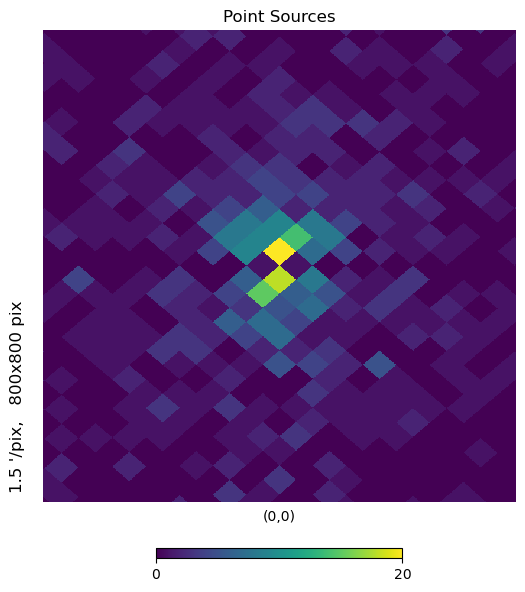

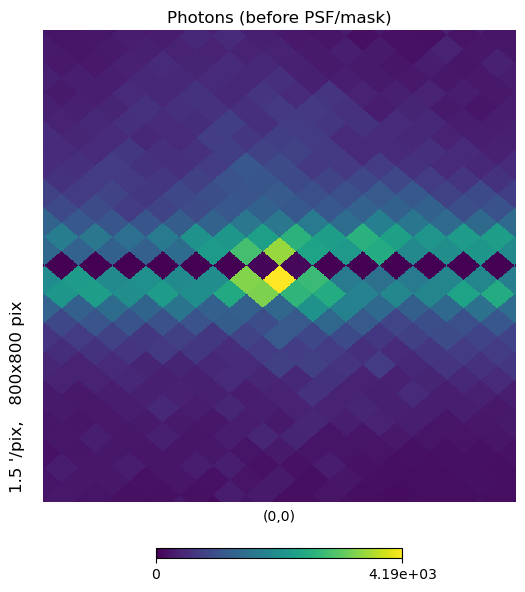

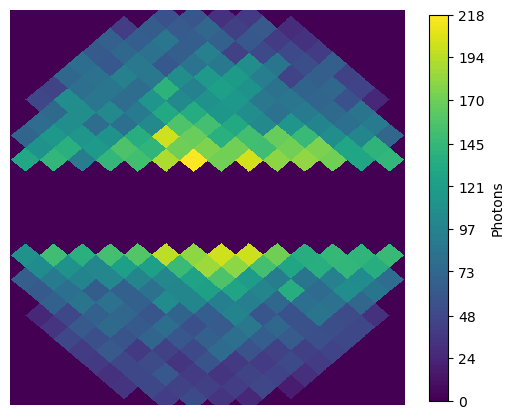

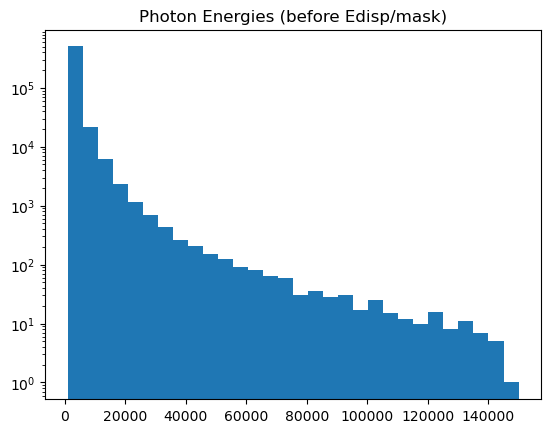

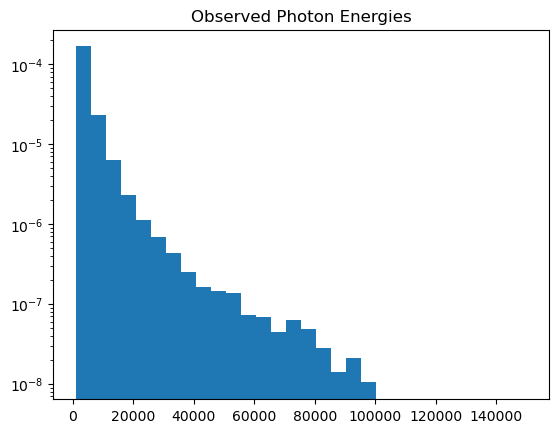

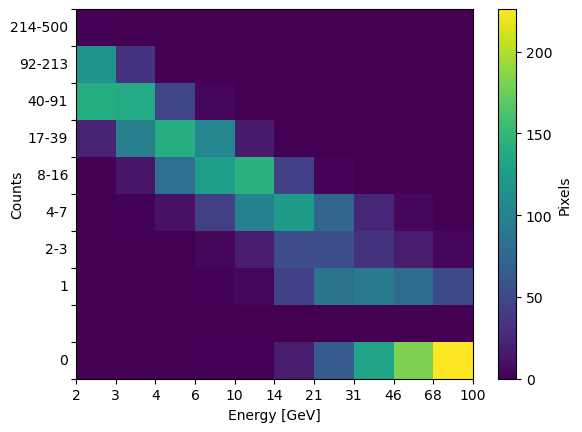

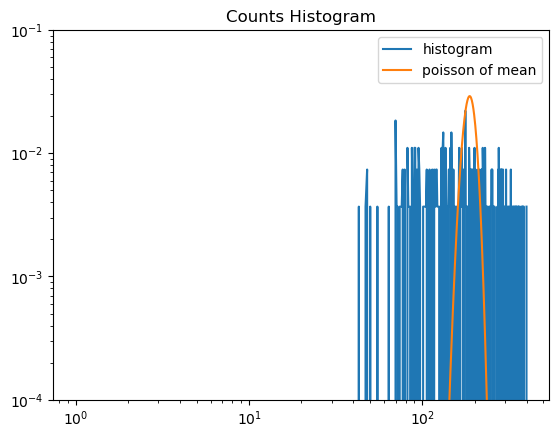

In [12]:
#input_params = [1.0, 5.0] #poisson only pulsars, only number normalizations
#input_params = [0.035, 0.25] #non-poisson only pulsars, only number normalizations
#input_params = [70000, 3] #DM mass and cross section
#input_params = [2., 6.0, 30000, 0] #poisson pulsars, only number normalizations, DM mass and cross section
input_params = [0.022, 0.25, 30000, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section
#input_params = [0.035, 0.25, 30000, 3, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section, Model O normalization
#input_params = [1., 3] #poisson run 6
#input_params = [0.035, 3] #nonpoisson run 6

source_info = my_LFI.create_sources(input_params, grains = 10000)
photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Point Sources', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photons (before PSF/mask)', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

N_Ebins = 10
Ebins = np.geomspace(my_LFI.Emin_mask + 0.1, my_LFI.Emax_mask + 0.1, N_Ebins + 1) - 0.1
roi_pix_i = my_LFI.get_roi_pix_indices(N_side)
first_Ebin_is = np.where(obs_photon_info['energies'] <= Ebins[1])
heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][first_Ebin_is,0], obs_photon_info['angles'][first_Ebin_is,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
for i in range(len(heatmap[0])):
    if i not in roi_pix_i:
        heatmap[0][i] = 0
hp.gnomview(heatmap[0], title = '', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5, notext = True, cbar = None)
plt.colorbar(cm.ScalarMappable(), shrink = 0.67, label = 'Photons', ticks = np.round(np.linspace(0, np.max(heatmap[0]), 10)).astype('int'), boundaries = np.linspace(0, np.max(heatmap[0]), 100), values = np.linspace(1, 10, 99))
plt.savefig('figures/ROI_map_hist.pdf', bbox_inches='tight', pad_inches = 0)

fig, ax = plt.subplots()
ax.set_title('Photon Energies (before Edisp/mask)')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

fig, ax = plt.subplots()
ax.set_title('Observed Photon Energies')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen, density = True)

N_Ebins = 10
roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = N_Ebins, Ebinspace = 'log')
Ebins = np.geomspace(my_LFI.Emin_mask + 0.1, my_LFI.Emax_mask + 0.1, N_Ebins + 1) - 0.1
print('Max count in any pixel/energy bin: ', np.max(roi_map))
mincount, maxcount, N_countbins = 0, 500, 10
counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = 'log')
countbins = np.geomspace(mincount + 0.1, maxcount + 0.1, N_countbins + 1) - 0.1
fig, ax = plt.subplots()
#ax.set_title('Energy-Dependent Histogram')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Counts', labelpad = 30)
ax.set_xticks(np.linspace(0, N_Ebins, N_Ebins+1))
ax.set_yticks(np.linspace(0, N_countbins, N_countbins+1))
ax.set_xticklabels(np.round(Ebins/1000).astype('int'))
count_ints = np.round(countbins).astype('int')
count_labels = ['0','','1']
for i, edge in enumerate(count_ints):
    if i > 2 and i < N_countbins:
        count_labels.append(str(count_ints[i]+1)+'-'+str(count_ints[i+1]))
for i, label in enumerate(count_labels):
    ax.annotate(count_labels[i], xy=(0, 0), xycoords=('axes fraction', 'axes fraction'),
        xytext=(-0.02, 0.05+0.1*i), va='center', ha='right')
ax.yaxis.set_major_formatter(ticker.NullFormatter())
mesh = ax.pcolormesh(counts_hist)
fig.colorbar(mesh, label = 'Pixels')
fig.savefig('figures/histogram_summary_labeled.pdf', bbox_inches='tight', pad_inches = 0)

fig, ax = plt.subplots()
ax.set_title('Counts Histogram')
for i in range(1):
    source_info = my_LFI.create_sources(input_params, grains = 10000)
    photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
    obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = 1, Ebinspace = 'log')
    if i == 0:
        counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
    else:
        counts_hist += my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
counts_hist /= np.sum(counts_hist)
counts_bins = np.linspace(0, 400, 401)
ax.plot(counts_bins[:-1], counts_hist, label = 'histogram')
mean = np.sum(counts_hist.T[0]*counts_bins[:-1])
plotc = np.linspace(0, 400, 401)
import scipy as sp
ax.plot(plotc, sp.stats.poisson.pmf(plotc, mean), label = 'poisson of mean')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-4, 1e-1)
ax.legend()

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(obs_photon_info['energies']))
print('Average photon energy: ', np.mean(obs_photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source (only valid when running single source): ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(obs_photon_info['energies'])*u.MeV.to('erg')*np.size(obs_photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Number of pixels: ', roi_map.shape[0])#round(12*N_side**2*(2*np.pi*(1 - np.cos(angular_cut)))/(4*np.pi)))
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

In [17]:
#overplot of contours

#input_params = torch.tensor([1., 3.0, 30000, 1]) #poisson 50/50
#input_params = torch.tensor([2., 6.0, 30000, 0]) #poisson no DM
#input_params = torch.tensor([0., 0., 30000, 2]) #poisson no PS
input_params = torch.tensor([0.022, 0.25, 30000, 1]) #non-poisson 50/50
#input_params = torch.tensor([0.044, 0.5, 30000, 0]) #non-poisson no DM
#input_params = torch.tensor([0., 0., 30000, 2]) #non-poisson no PS

#file = 'figures/summary_poisson_5050.pdf'
#file = 'figures/summary_poisson_noDM.pdf'
#file = 'figures/summary_poisson_noPS.pdf'
file = 'figures/summary_nonpoisson_5050.pdf'
#file = 'figures/summary_nonpoisson_noDM.pdf'
#file = 'figures/summary_nonpoisson_noPS.pdf'

static_observation = True #prevents simulator(s) from generating unique photons when called if True
load_sopi =  False #sets the static observation to the saved pickle

################################################################################################################################
static_source_info = my_LFI.create_sources(input_params.numpy(), grains = 4000)
static_photon_info = my_LFI.generate_photons_from_sources(input_params.numpy(), static_source_info, grains = 1000)
static_obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
static_obs_photon_info = my_LFI.mock_observe(static_photon_info, static_obs_info)
if load_sopi:
    static_obs_photon_info = np.load(file[:-4] + '.npy', allow_pickle=True)[()]
    
def simulator1(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_counts.flatten()
def simulator2(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 1
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_counts.flatten()
def simulator3(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return np.sum(heatmap_roi, axis = 0)
def simulator4(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_combined
def simulator5(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return np.sum(heatmap_roi, axis = 1)
def simulator6(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_roi.flatten()
def simulator7(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return np.sum(heatmap_roi, axis = 0)/np.sum(heatmap_roi)
simulators = [simulator1, simulator2, simulator3, simulator4, simulator5, simulator6, simulator7, simulator1, simulator7, simulator1, simulator7]

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


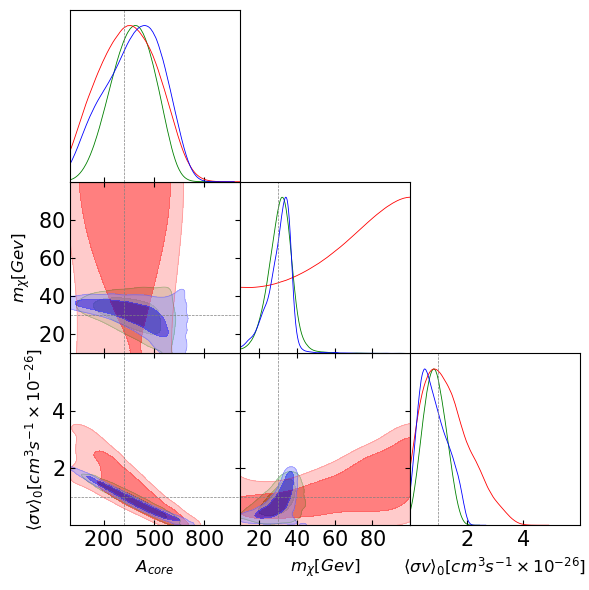

In [20]:
#networks = ['run9a_poisson/100000sims', 'run9b_poisson/100000sims', 'run9c_poisson/100000sims', 'run9d_poisson/100000sims', 'run9e_poisson/100000sims', 'run9f_poisson/100000sims', 'run9g_poisson/100000sims']
networks = ['run9a_nonpoisson/100000sims', 'run9b_nonpoisson/100000sims', 'run9c_nonpoisson/100000sims', 'run9d_nonpoisson/100000sims', 'run9e_nonpoisson/100000sims', 'run9f_nonpoisson/100000sims', 'run9g_nonpoisson/100000sims', 'run9h_nonpoisson/100000sims', 'run9i_nonpoisson/100000sims', 'run9j_nonpoisson/100000sims', 'run9k_nonpoisson/100000sims']
labels = ['Energy + Direction', 'Direction', 'Energy', 'Map+Histogram', 'Only Counts Map', 'Full Map', 'Normalized Energy Map', 'Histogram Fixed DM Spectrum', 'Normalixed Energy Histogram Fixed DM Spectrum', 'Histogram Fixed DM&MSP Spectra', 'Normalixed Energy Histogram Fixed DM&MSP Spectra']
num_overplots = 1
include_network = [True, True, True, False, False, False, False, False, False, False, False]
colors = ['g','r','b']

A_Disk_conversion_fac = 14482.4 #nonpoisson
sigmav_conversion_fac = 1
new_parameter_range = [[A_Disk_conversion_fac*parameter_range[0][0], 0.001*parameter_range[0][2], sigmav_conversion_fac*parameter_range[0][3]], [A_Disk_conversion_fac*parameter_range[1][0], 0.001*parameter_range[1][2], sigmav_conversion_fac*6]]
new_parameter_names = [parameter_names[0], parameter_names[2] + r'[Gev]', r'\langle\sigma v\rangle_0[cm^3s^{-1}\times 10^{-26}]']
new_markers = [A_Disk_conversion_fac*input_params[0], 0.001*input_params[2], sigmav_conversion_fac*input_params[3]]
g = plots.get_subplot_plotter()
#g.settings.title_limit = 1
#g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize = 18
g.settings.legend_fontsize = 18
g.settings.legend_loc = 'upper right'
g.settings.axes_labelsize = 15
g.settings.norm_1d_density = True
g.settings.line_labels =False
samps = []
for ni, network in enumerate(networks):
    if include_network[ni]:
        for i in range(num_overplots):
            posterior_file = 'posteriors/' + network
            posterior = np.load(posterior_file + '.npy', allow_pickle=True)[()]
            observation = simulators[ni](input_params)
            #print(observation)
            samples = posterior.sample((10000,), x=observation) #100000
            #print(parameter )
            #log_probability = posterior.log_prob(samples, x=observation)
            ranges = dict(zip(['a','c','d'], np.array(new_parameter_range).T.reshape((np.array(new_parameter_range[0]).size,2))))
            #label = network + f' data set {i+1}' 
            label = labels[ni]
            modified_samps = samples.numpy()[:,[0,2,3]]
            modified_samps[:,0] *= A_Disk_conversion_fac
            modified_samps[:,1] *= 0.001
            modified_samps[:,2] *= sigmav_conversion_fac
            samps.append(MCSamples(samples=modified_samps, names = ['a','c','d'], labels = new_parameter_names, label = label, ranges = ranges))
g.triangle_plot(samps, filled=True, markers=new_markers, contour_args = {'alpha': .5}, param_limits=ranges, contour_colors = colors, norm_1d_density = True)

In [21]:
#g.export(file)
#np.save(file[:-4], static_obs_photon_info, allow_pickle=True)

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


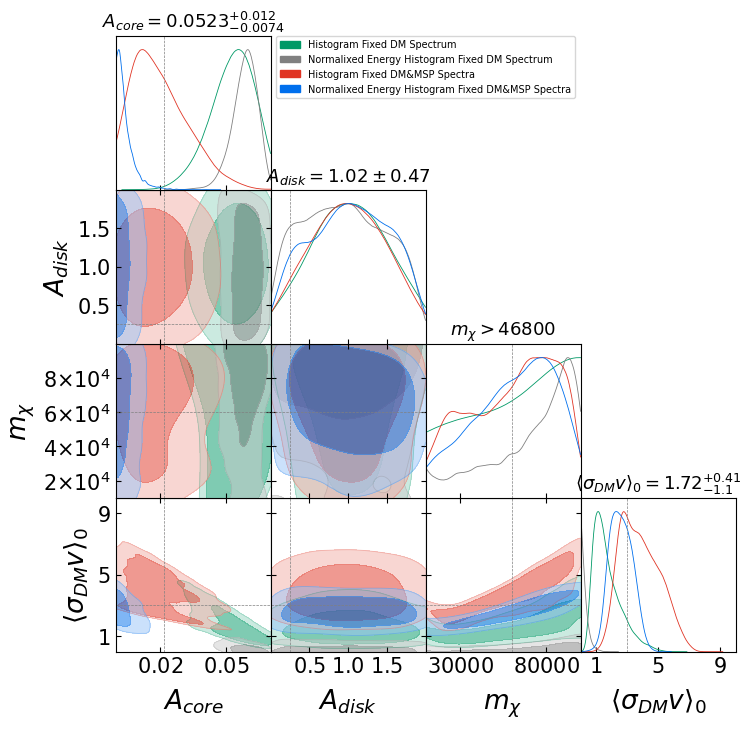

In [15]:
#networks = ['run9a_poisson/100000sims', 'run9b_poisson/100000sims', 'run9c_poisson/100000sims', 'run9d_poisson/100000sims', 'run9e_poisson/100000sims', 'run9f_poisson/100000sims', 'run9g_poisson/100000sims']
networks = ['run9a_nonpoisson/100000sims', 'run9b_nonpoisson/100000sims', 'run9c_nonpoisson/100000sims', 'run9d_nonpoisson/100000sims', 'run9e_nonpoisson/100000sims', 'run9f_nonpoisson/100000sims', 'run9g_nonpoisson/100000sims', 'run9h_nonpoisson/100000sims', 'run9i_nonpoisson/100000sims', 'run9j_nonpoisson/100000sims', 'run9k_nonpoisson/100000sims']
labels = ['Full Histogram', 'Only Counts Histogram', 'Only Energy Map', 'Map+Histogram', 'Only Counts Map', 'Full Map', 'Normalized Energy Map', 'Histogram Fixed DM Spectrum', 'Normalixed Energy Histogram Fixed DM Spectrum', 'Histogram Fixed DM&MSP Spectra', 'Normalixed Energy Histogram Fixed DM&MSP Spectra']
num_overplots = 1
include_network = [False, False, False, False, False, False, False, True, True, True, True]

g = plots.get_subplot_plotter()
g.settings.title_limit = 1
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 10
g.settings.axes_labelsize = 22
samps = []
for ni, network in enumerate(networks):
    if include_network[ni]:
        for i in range(num_overplots):
            posterior_file = 'posteriors/' + network
            posterior = np.load(posterior_file + '.npy', allow_pickle=True)[()]
            observation = simulators[ni](input_params)
            #print(observation)
            samples = posterior.sample((10000,), x=observation) #100000
            #print(parameter )
            #log_probability = posterior.log_prob(samples, x=observation)
            ranges = dict(zip(['a','b','c','d'], np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
            #label = network + f' data set {i+1}' 
            label = labels[ni]
            samps.append(MCSamples(samples=samples.numpy(), names = ['a','b','c','d'], labels = parameter_names, label = label, ranges = ranges))
g.triangle_plot(samps, filled=True, markers=input_params.numpy(), contour_args = {'alpha': .5}, param_limits=ranges)

In [40]:
#g.export(file)